#### Se importan las librerias necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

from bokeh.plotting import figure, output_file, show
from matplotlib.colors import ListedColormap
from PIL import Image
from wordcloud import WordCloud
from math import log, sqrt

#### Se carga la información del csv principal a un dataframe.

In [2]:
tweets = pd.read_csv('../TP1-Organizacion-de-Datos/csv/train.csv')
tweets.sample(n=5)

,id,keyword,location,text,target
6461,9244,sunk,NaN,literally just sunk in we got backty school in...,0
1660,2397,collapsed,NaN,Look: #I have collapsed #after attempting to m...,0
3892,5534,flattened,"Wahpeton, ND",Picking up flattened hay men (@ Masonite in Wa...,0
1659,2396,collapsed,wherever-the-fuck washington,@flickershowell oh wow my heart collapsed cool...,1
3202,4596,emergency%20plan,"Augusta, GA",County 911 Overload Prompts Use of Emergency P...,0


##### Se reemplaza la columna 'target' por 'about_disaster' para mayor comodidad y se agregan 'char_length' y 'word_length'

In [3]:
tweets_final = tweets.rename(columns={'target':'about_disaster'})
tweets_final['about_disaster'] = ((tweets_final['about_disaster'])==1)
tweets_final['char_length'] = (tweets_final['text']).str.len()
tweets_final['keyword'] = tweets_final['keyword'].str.replace('%20', '_')
tweets_final.head()

,id,keyword,location,text,about_disaster,char_length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,True,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,True,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,True,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",True,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,True,88


In [4]:
palabras = tweets_final['text'].str.split()
aux = []
for i in palabras:
    aux.append(len(i))

tweets_final['word_length'] = aux
tweets_final.head()

,id,keyword,location,text,about_disaster,char_length,word_length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,True,69,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,True,38,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,True,133,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",True,65,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,True,88,16


# Veracidad por keyword

In [5]:
tweets_final['keyword'].fillna("none_keyword", inplace=True)

#### Se agrupa por keyword y se calcula valores relevantes a lo que se busca estudiar (cantidad de tweets veraces y totales, y longitud promedio de los tweets totales, veraces y no veraces por keyword).

In [6]:
tweets_por_keyword = tweets_final.groupby(['keyword'])\
                    .agg({'about_disaster':['sum','count'],'char_length':['mean'], 'word_length':['mean']})
    
tweets_por_keyword.head()

about_disaster       char_length word_length
                             sum count        mean        mean
keyword                                                       
ablaze                      13.0    36   94.694444   13.916667
accident                    24.0    35  100.085714   15.257143
aftershock                   0.0    34  101.205882   14.911765
airplane_accident           30.0    35  106.400000   15.314286
ambulance                   20.0    38   98.394737   12.815789

In [7]:
tweets_por_keyword.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222 entries, ablaze to wrecked
Data columns (total 4 columns):
(about_disaster, sum)      222 non-null float64
(about_disaster, count)    222 non-null int64
(char_length, mean)        222 non-null float64
(word_length, mean)        222 non-null float64
dtypes: float64(3), int64(1)
memory usage: 8.7+ KB


#### Se elimina el MultiIndex

In [8]:
nivel0 = tweets_por_keyword.columns.get_level_values(0)
nivel1 = tweets_por_keyword.columns.get_level_values(1)
tweets_por_keyword.columns = nivel0 + '_' + nivel1
tweets_por_keyword.head()

,about_disaster_sum,about_disaster_count,char_length_mean,word_length_mean
keyword,,,,
ablaze,13.0,36,94.694444,13.916667
accident,24.0,35,100.085714,15.257143
aftershock,0.0,34,101.205882,14.911765
airplane_accident,30.0,35,106.400000,15.314286
ambulance,20.0,38,98.394737,12.815789


#### Se renombran y reordenan las columnas para mayor claridad

In [9]:
nuevos_nombres = {'about_disaster_sum':'about_disaster_true', 'about_disaster_count':'count'}
tweets_por_keyword.rename(columns=nuevos_nombres, inplace=True)
tweets_por_keyword.head()

,about_disaster_true,count,char_length_mean,word_length_mean
keyword,,,,
ablaze,13.0,36,94.694444,13.916667
accident,24.0,35,100.085714,15.257143
aftershock,0.0,34,101.205882,14.911765
airplane_accident,30.0,35,106.400000,15.314286
ambulance,20.0,38,98.394737,12.815789


In [10]:
tweets_por_keyword['about_disaster_false'] = tweets_por_keyword['count'] - tweets_por_keyword['about_disaster_true']
tweets_por_keyword['veracity'] =  tweets_por_keyword['about_disaster_true']/tweets_por_keyword['count']
tweets_por_keyword = tweets_por_keyword[['about_disaster_true', 'about_disaster_false', 'count', 'veracity', 'char_length_mean', 'word_length_mean']]
tweets_por_keyword.sort_values(by='veracity', ascending=False, inplace=True)
tweets_por_keyword.head(10)

,about_disaster_true,about_disaster_false,count,veracity,char_length_mean,word_length_mean
keyword,,,,,,
wreckage,39.0,0.0,39,1.000000,122.256410,16.000000
derailment,39.0,0.0,39,1.000000,109.794872,15.282051
debris,37.0,0.0,37,1.000000,107.594595,14.891892
outbreak,39.0,1.0,40,0.975000,128.925000,17.550000
typhoon,37.0,1.0,38,0.973684,111.394737,13.473684
oil_spill,37.0,1.0,38,0.973684,102.973684,13.789474
suicide_bombing,32.0,1.0,33,0.969697,108.575758,15.757576
suicide_bomber,30.0,1.0,31,0.967742,109.032258,15.000000
bombing,27.0,2.0,29,0.931034,102.482759,13.655172


#### Se observa el promedio de tweets por keyword para filtrar aquellas que obstruyan el análisis estadístico

In [11]:
tweets_por_keyword['count'].mean()

34.292792792792795

In [12]:
tweets_por_keyword[tweets_por_keyword['count']<34].count()

about_disaster_true     77
about_disaster_false    77
count                   77
veracity                77
char_length_mean        77
word_length_mean        77
dtype: int64

#### Al enfocar el análisis estadístico a aquellas keywords que posean 34 o más tweets, se dejan de lado 77 keywords (alrededor del 35% del total).

In [13]:
tweets_por_keyword['count'].value_counts()

35    31
34    30
33    26
36    20
37    19
38    16
32    15
39    14
31     9
29     8
40     7
30     6
41     4
42     2
28     2
27     2
22     1
10     1
11     1
12     1
19     1
61     1
24     1
25     1
26     1
45     1
9      1
Name: count, dtype: int64

In [14]:
tweets_por_keyword[tweets_por_keyword['count']<29].count()

about_disaster_true     13
about_disaster_false    13
count                   13
veracity                13
char_length_mean        13
word_length_mean        13
dtype: int64

#### Al enfocarse en aquellas que tienen 29 o más tweets, el espectro estudiado aumenta claramente. Además, en este caso, 29 no es una diferencia significativa del promedio.

In [15]:
keywords_representables = (tweets_por_keyword[tweets_por_keyword['count']>=29])
keywords_veraces = keywords_representables.head(20)
keywords_no_veraces = keywords_representables.tail(20)

#### Se procede a graficar

Text(0.5, 1.0, 'Top 20 Keywords con mejor porcentaje de veracidad')

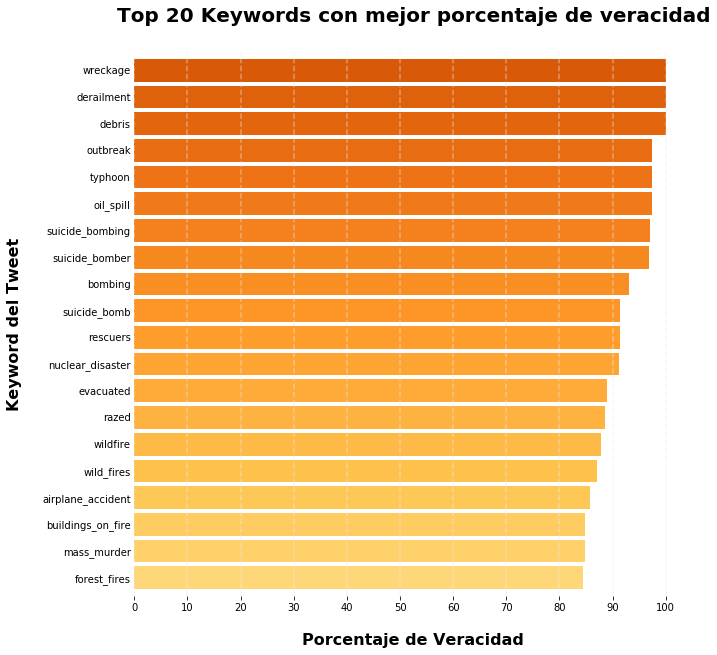

In [16]:
cmap = cm.get_cmap('YlOrBr')
saltos = np.linspace(0.3, 0.7, 20)
colores = cmap(saltos)
top20 = (keywords_veraces['veracity']*100).sort_values().plot(kind='barh', figsize=(10,10), color=colores, width=0.85)

plt.xticks(np.arange(0, 100+1, 10.0))
plt.tick_params(axis='y', length=0)

top20.spines['right'].set_visible(False)
top20.spines['top'].set_visible(False)
top20.spines['left'].set_visible(False)
top20.spines['bottom'].set_visible(False)

lineas = top20.get_xticks()
for i in lineas:
      top20.axvline(x=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
top20.set_xlabel("Porcentaje de Veracidad", labelpad=20, weight='bold', size=16)
top20.set_ylabel("Keyword del Tweet", labelpad=20, weight='bold', size=16)

plt.title("Top 20 Keywords con mejor porcentaje de veracidad", weight='bold', size=20, pad=30)

Text(0.5, 1.0, 'Top 20 Keywords con peor porcentaje de veracidad')

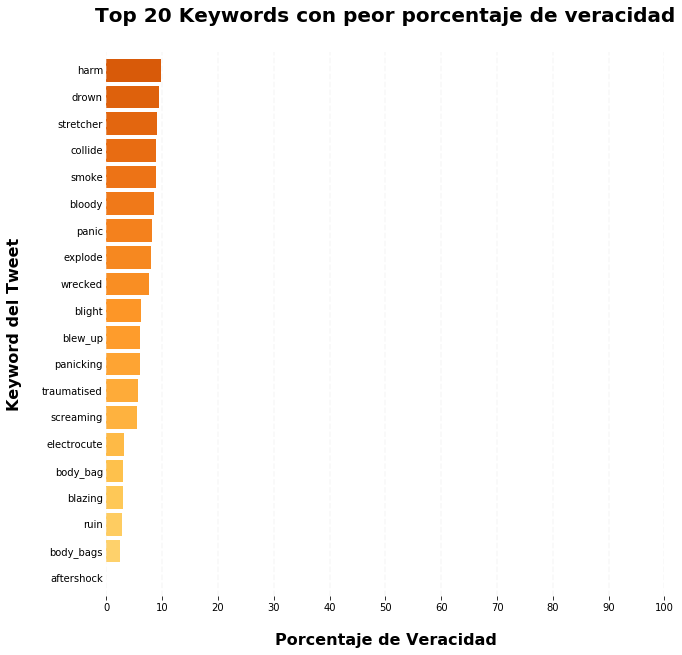

In [17]:
worst20 = (keywords_no_veraces['veracity']*100).sort_values().plot(kind='barh', figsize=(10,10), color=colores, width=0.85)

plt.xticks(np.arange(0, 100+1, 10.0))
plt.tick_params(axis='y', length=0)

worst20.spines['right'].set_visible(False)
worst20.spines['top'].set_visible(False)
worst20.spines['left'].set_visible(False)
worst20.spines['bottom'].set_visible(False)

lineas = worst20.get_xticks()
for i in lineas:
      worst20.axvline(x=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
worst20.set_xlabel("Porcentaje de Veracidad", labelpad=20, weight='bold', size=16)
worst20.set_ylabel("Keyword del Tweet", labelpad=20, weight='bold', size=16)

plt.title("Top 20 Keywords con peor porcentaje de veracidad", weight='bold', size=20, pad=30)

Text(0.5, 1.0, 'Cantidad de Keywords por porcentaje de veracidad')

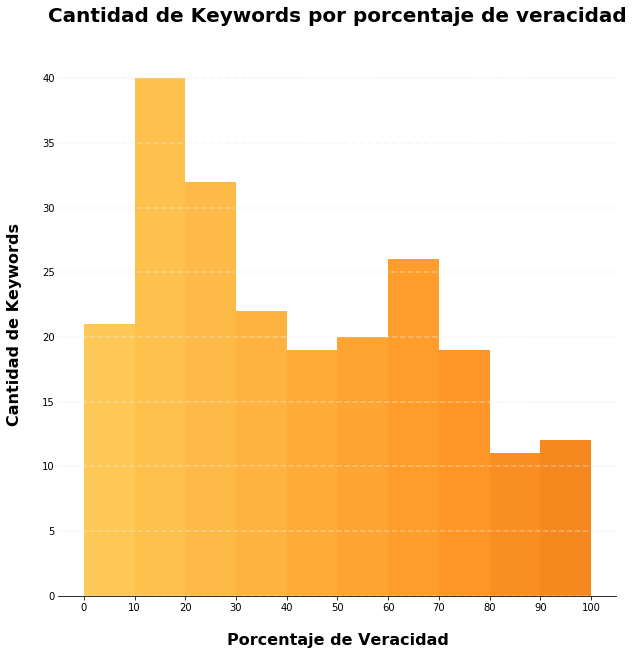

In [18]:
plt.figure(figsize=(10,10))    
n, bins, patches = plt.hist(tweets_por_keyword["veracity"]*100, bins=10, color="c")
hist_porcentajes = plt.gca()

for i,p in enumerate(patches):
    plt.setp(p, "facecolor", colores[i+3])

plt.xticks(np.arange(0, 100+1, 10.0))
plt.yticks(np.arange(0, 40+1, 5.0))
plt.tick_params(axis='y', length=0)

hist_porcentajes.spines['right'].set_visible(False)
hist_porcentajes.spines['top'].set_visible(False)
hist_porcentajes.spines['left'].set_visible(False)

lineas = hist_porcentajes.get_yticks()
for i in lineas:
      hist_porcentajes.axhline(y=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
hist_porcentajes.set_xlabel("Porcentaje de Veracidad", labelpad=20, weight='bold', size=16)
hist_porcentajes.set_ylabel("Cantidad de Keywords", labelpad=20, weight='bold', size=16)

plt.title("Cantidad de Keywords por porcentaje de veracidad", weight='bold', size=20, pad=30)

Text(0.5, 1.0, 'Longitud promedio (en caracteres) de los tweets \ncon las 20 keywords más veraces')

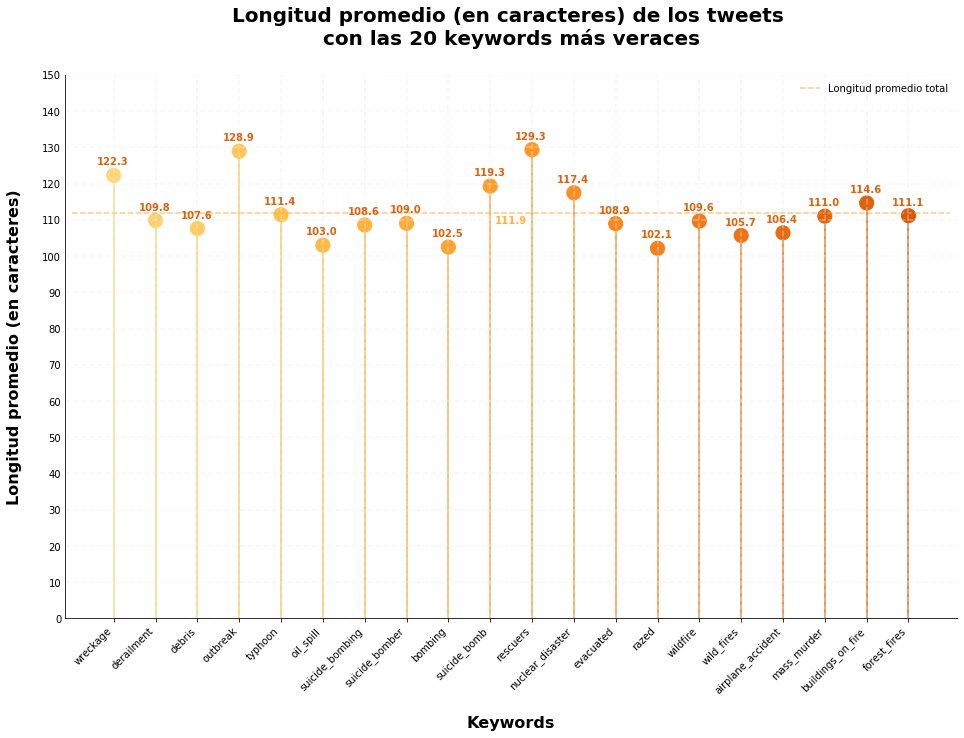

In [19]:
plt.figure(figsize=(16,10)) 
top20 = plt.subplot()

saltos_x = np.arange(0, 20, 1.0)
longitud_promedio = keywords_veraces['char_length_mean'].mean()

top20.hlines(y=longitud_promedio, xmin=-1, xmax=20, color=colores[8], \
                  alpha=0.6, linestyle = '--', label='Longitud promedio total')

top20.vlines(x=range(0,20,1), ymin=0, ymax=keywords_veraces['char_length_mean'], color=colores, \
                linestyle = '-')

top20.scatter(x=keywords_veraces.index.tolist(), y=keywords_veraces['char_length_mean'],\
                     color=colores, alpha=1, s=200)

plt.xticks(saltos_x)
plt.xticks(rotation=45, ha='right')
plt.yticks(np.arange(0, 160, 10.0))

top20.spines['right'].set_visible(False)
top20.spines['top'].set_visible(False)
plt.tick_params(axis='y', length=0)

lineas_x = top20.get_xticks()
for i in lineas_x:
      top20.axvline(x=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
lineas_y = top20.get_yticks()
for i in lineas_y:
      top20.axhline(y=i, linestyle='--', alpha=0.4, color='#eeeeee')
        

for x, y in enumerate(keywords_veraces['char_length_mean']):
    top20.text(x-.4, y + 2.9, str(round(y,1)), color=colores[18], fontweight='bold', fontsize=10)
    
top20.text(9.1, longitud_promedio-3, str(round(longitud_promedio,1)), color=colores[6], fontweight='bold', fontsize=10)        
top20.set_xlabel("Keywords", labelpad=20, weight='bold', size=16)
top20.set_ylabel("Longitud promedio (en caracteres)", labelpad=20, weight='bold', size=16)

top20.legend(frameon=False, loc='best', ncol=2)

plt.title("Longitud promedio (en caracteres) de los tweets \ncon las 20 keywords más veraces", weight='bold', size=20, pad=30)

Text(0.5, 1.0, 'Longitud promedio (en caracteres) de los tweets \ncon las 20 keywords menos veraces')

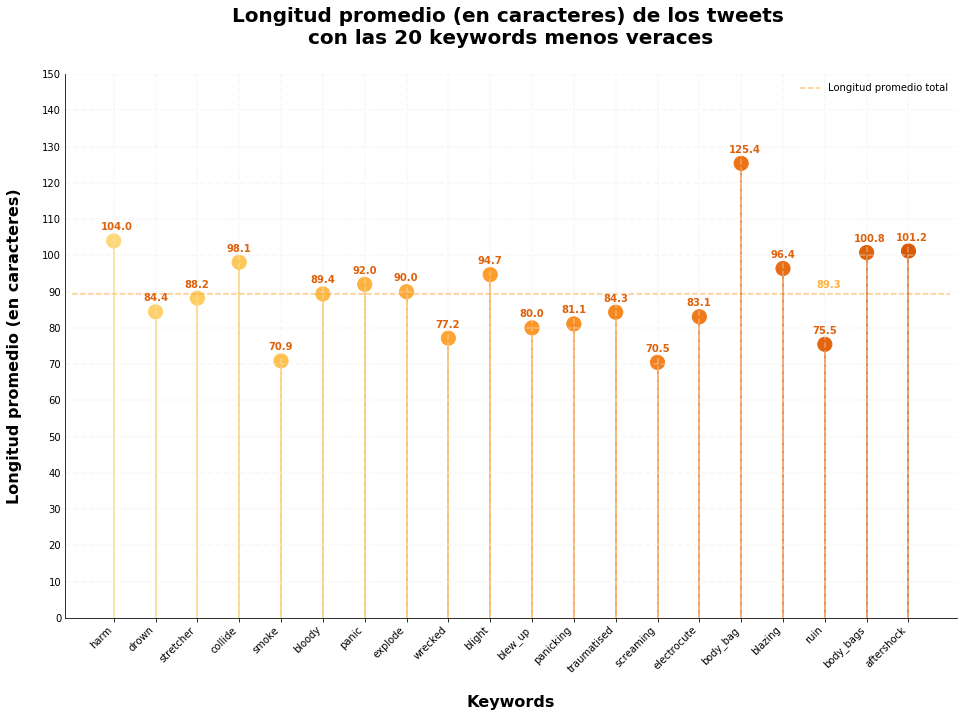

In [20]:
plt.figure(figsize=(16,10)) 
worst20 = plt.subplot()

saltos_x = np.arange(0, 20, 1.0)
longitud_promedio = keywords_no_veraces['char_length_mean'].mean()

worst20.hlines(y=longitud_promedio, xmin=-1, xmax=20, color=colores[8], \
                  alpha=0.6, linestyle = '--', label='Longitud promedio total')

worst20.vlines(x=range(0,20,1), ymin=0, ymax=keywords_no_veraces['char_length_mean'], color=colores, \
                  linestyle = '-')

worst20.scatter(x=keywords_no_veraces.index.tolist(), y=keywords_no_veraces['char_length_mean'],\
                     color=colores, alpha=1, s=200)

plt.xticks(saltos_x)
plt.xticks(rotation=45, ha='right')
plt.yticks(np.arange(0, 160, 10.0))

worst20.spines['right'].set_visible(False)
worst20.spines['top'].set_visible(False)
plt.tick_params(axis='y', length=0)

lineas_x = worst20.get_xticks()
for i in lineas_x:
      worst20.axvline(x=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
lineas_y = worst20.get_yticks()
for i in lineas_y:
      worst20.axhline(y=i, linestyle='--', alpha=0.4, color='#eeeeee')
        

for x, y in enumerate(keywords_no_veraces['char_length_mean']):
    worst20.text(x-.3, y+2.9, str(round(y,1)), color=colores[18], fontweight='bold', fontsize=10)
    
worst20.text(16.8, longitud_promedio+1.7, str(round(longitud_promedio,1)), color=colores[6], fontweight='bold', fontsize=10)        
worst20.set_xlabel("Keywords", labelpad=20, weight='bold', size=16)
worst20.set_ylabel("Longitud promedio (en caracteres)", labelpad=20, weight='bold', size=16)

worst20.legend(frameon=False, loc='best', ncol=2)

plt.title("Longitud promedio (en caracteres) de los tweets \ncon las 20 keywords menos veraces", weight='bold', size=20, pad=30)


Text(0.5, 1.0, 'Longitud promedio (en palabras) de los tweets \ncon las 20 keywords más veraces')

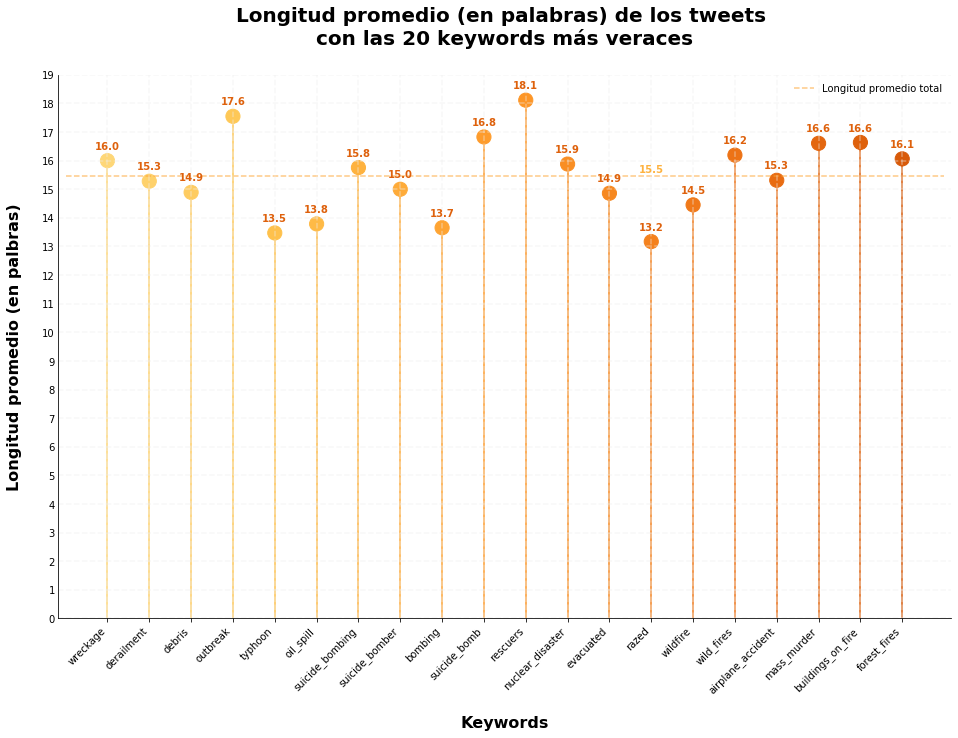

In [21]:
plt.figure(figsize=(16,10)) 
top20 = plt.subplot()

saltos_x = np.arange(0, 20, 1.0)
longitud_promedio = keywords_veraces['word_length_mean'].mean()

top20.hlines(y=longitud_promedio, xmin=-1, xmax=20, color=colores[8], \
                  alpha=0.6, linestyle = '--', label='Longitud promedio total')

top20.vlines(x=range(0,20,1), ymin=0, ymax=keywords_veraces['word_length_mean'], color=colores, \
                linestyle = '-')

top20.scatter(x=keywords_veraces.index.values.tolist(), y=keywords_veraces['word_length_mean'],\
                     color=colores, alpha=1, s=200)

plt.xticks(saltos_x)
plt.xticks(rotation=45, ha='right')
plt.yticks(np.arange(0, 20, 1.0))

top20.spines['right'].set_visible(False)
top20.spines['top'].set_visible(False)
plt.tick_params(axis='y', length=0)

lineas_x = top20.get_xticks()
for i in lineas_x:
        top20.axvline(x=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
lineas_y = top20.get_yticks()
for i in lineas_y:
        top20.axhline(y=i, linestyle='--', alpha=0.4, color='#eeeeee')
        

for x, y in enumerate(keywords_veraces['word_length_mean']):
        top20.text(x-.3, y+.4, str(round(y,1)), color=colores[18], fontweight='bold', fontsize=10)
    
top20.text(12.7, longitud_promedio+.1, str(round(longitud_promedio,1)), color=colores[6], fontweight='bold', fontsize=10)        
top20.set_xlabel("Keywords", labelpad=20, weight='bold', size=16)
top20.set_ylabel("Longitud promedio (en palbras)", labelpad=20, weight='bold', size=16)

top20.legend(frameon=False, loc='best', ncol=2)

plt.title("Longitud promedio (en palabras) de los tweets \ncon las 20 keywords más veraces", weight='bold', size=20, pad=30)


Text(0.5, 1.0, 'Longitud promedio (en palabras) de los tweets \ncon las 20 keywords menos veraces')

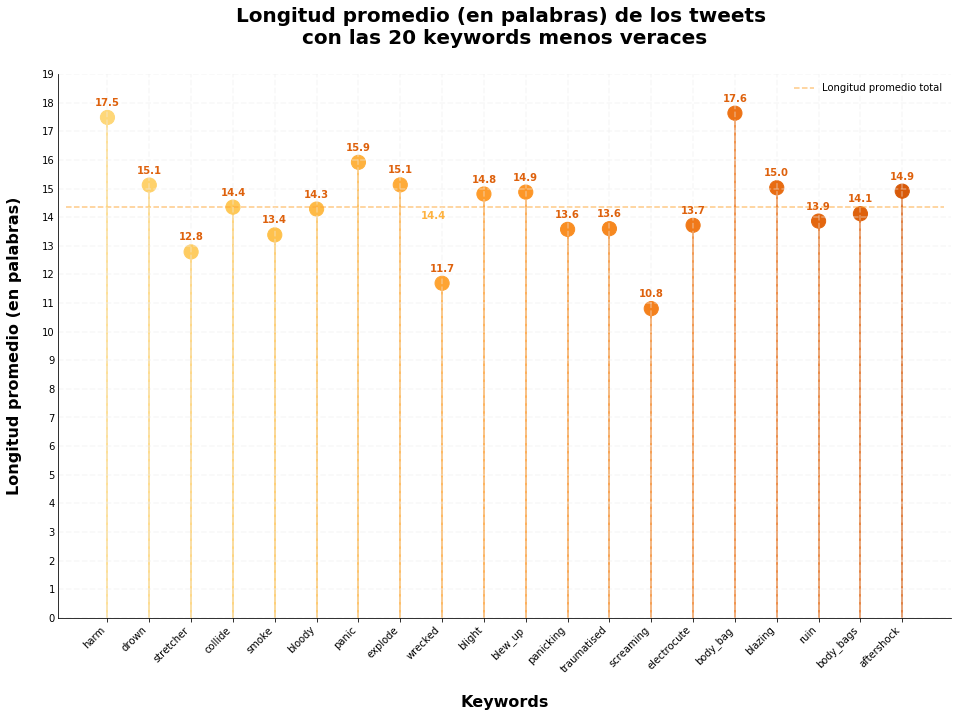

In [22]:
plt.figure(figsize=(16,10)) 
worst20 = plt.subplot()

saltos_x = np.arange(0, 20, 1.0)
longitud_promedio = keywords_no_veraces['word_length_mean'].mean()

worst20.hlines(y=longitud_promedio, xmin=-1, xmax=20, color=colores[8], \
                  alpha=0.6, linestyle = '--', label='Longitud promedio total')

worst20.vlines(x=range(0,20,1), ymin=0, ymax=keywords_no_veraces['word_length_mean'], color=colores, \
                  linestyle = '-')

worst20.scatter(x=keywords_no_veraces.index.values.tolist(), y=keywords_no_veraces['word_length_mean'],\
                     color=colores, alpha=1, s=200)

plt.xticks(saltos_x)
plt.xticks(rotation=45, ha='right')
plt.yticks(np.arange(0, 20, 1.0))

worst20.spines['right'].set_visible(False)
worst20.spines['top'].set_visible(False)
plt.tick_params(axis='y', length=0)

lineas_x = worst20.get_xticks()
for i in lineas_x:
        worst20.axvline(x=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
lineas_y = worst20.get_yticks()
for i in lineas_y:
        worst20.axhline(y=i, linestyle='--', alpha=0.4, color='#eeeeee')
        

for x, y in enumerate(keywords_no_veraces['word_length_mean']):
        worst20.text(x-.3, y+.4, str(round(y,1)), color=colores[18], fontweight='bold', fontsize=10)
    
worst20.text(7.5, longitud_promedio-.4, str(round(longitud_promedio,1)), color=colores[6], fontweight='bold', fontsize=10)        
worst20.set_xlabel("Keywords", labelpad=20, weight='bold', size=16)
worst20.set_ylabel("Longitud promedio (en palabras)", labelpad=20, weight='bold', size=16)

worst20.legend(frameon=False, loc='best', ncol=2)

plt.title("Longitud promedio (en palabras) de los tweets \ncon las 20 keywords menos veraces", weight='bold', size=20, pad=30)

Text(0.5, 1.0, 'Top 20 Keywords con mayor longitud de tweets (en caracteres)')

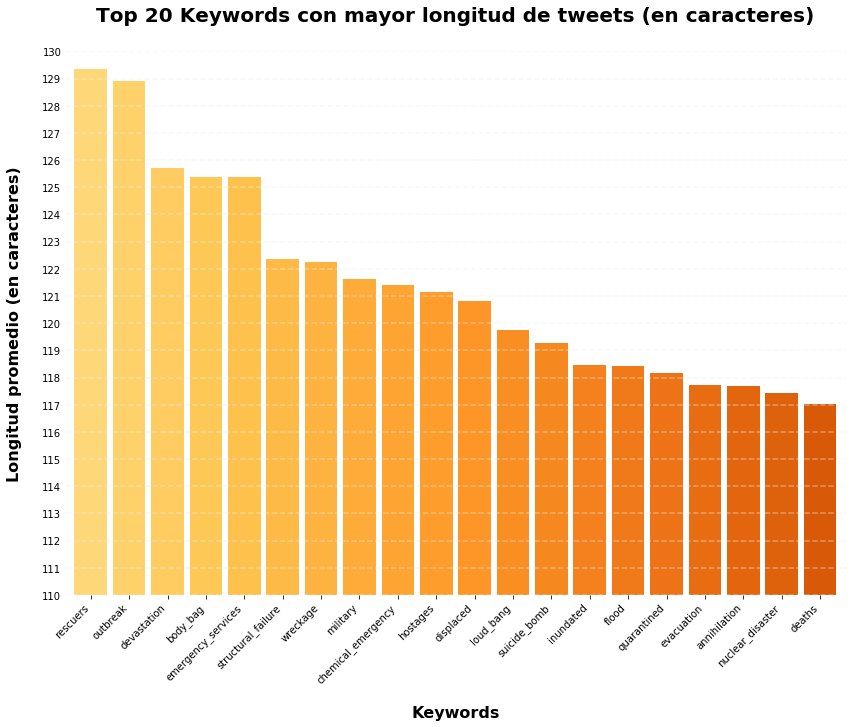

In [23]:
top20largas_c = (keywords_representables['char_length_mean']).sort_values(ascending=False).head(20)\
                .plot(kind='bar', figsize=(14,10), color=colores, width=0.85)

plt.xticks(rotation=45, ha='right')    
plt.yticks(np.arange(110, 135, 1.0))
plt.tick_params(axis='y', length=0)
plt.ylim(110, 130)

top20largas_c.spines['right'].set_visible(False)
top20largas_c.spines['top'].set_visible(False)
top20largas_c.spines['left'].set_visible(False)
top20largas_c.spines['bottom'].set_visible(False)

lineas = top20largas_c.get_yticks()
for i in lineas:
      top20largas_c.axhline(y=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
top20largas_c.set_xlabel("Keywords", labelpad=20, weight='bold', size=16)
top20largas_c.set_ylabel("Longitud promedio (en caracteres)", labelpad=20, weight='bold', size=16)

plt.title("Top 20 Keywords con mayor longitud de tweets (en caracteres)", weight='bold', size=20, pad=30)

Text(0.5, 1.0, 'Top 20 Keywords con menor longitud de tweets (en caracteres)')

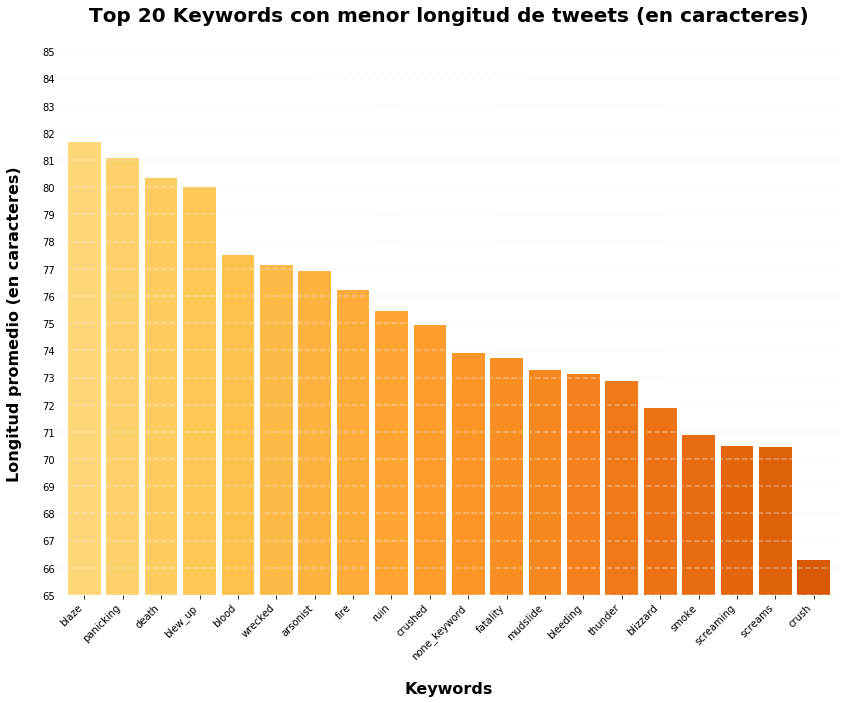

In [24]:
top20cortas_c = (keywords_representables['char_length_mean']).sort_values(ascending=False).tail(20)\
                .plot(kind='bar', figsize=(14,10), color=colores, width=0.85)

plt.xticks(rotation=45, ha='right')    
plt.yticks(np.arange(65, 90, 1.0))
plt.tick_params(axis='y', length=0)
plt.ylim(65, 85)

top20cortas_c.spines['right'].set_visible(False)
top20cortas_c.spines['top'].set_visible(False)
top20cortas_c.spines['left'].set_visible(False)
top20cortas_c.spines['bottom'].set_visible(False)

lineas = top20cortas_c.get_yticks()
for i in lineas:
      top20cortas_c.axhline(y=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
top20cortas_c.set_xlabel("Keywords", labelpad=20, weight='bold', size=16)
top20cortas_c.set_ylabel("Longitud promedio (en caracteres)", labelpad=20, weight='bold', size=16)

plt.title("Top 20 Keywords con menor longitud de tweets (en caracteres)", weight='bold', size=20, pad=30)

Text(0.5, 1.0, 'Top 20 Keywords con mayor longitud de tweets (en palabras)')

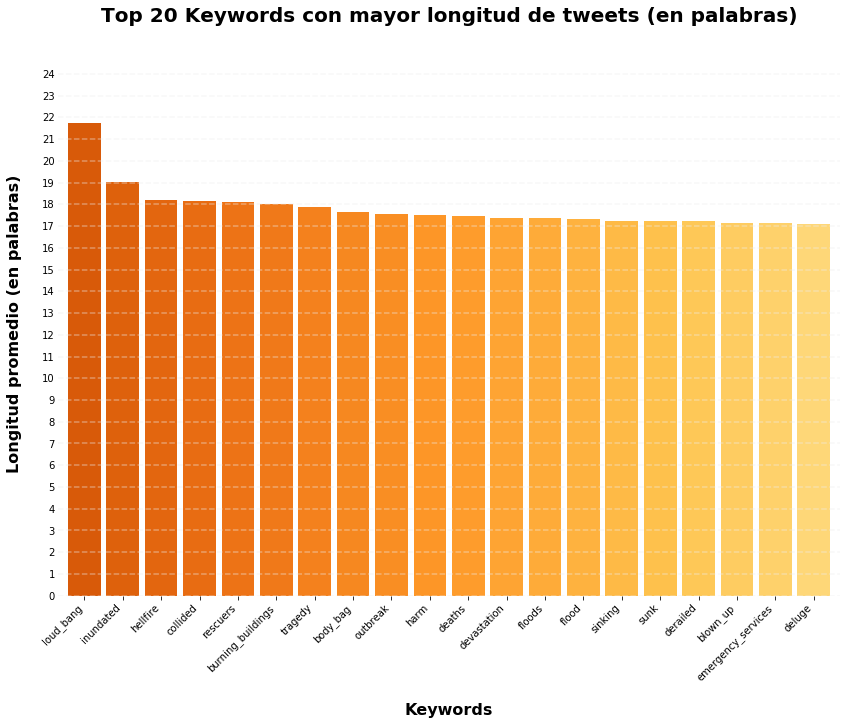

In [25]:
top20largas_w = (keywords_representables['word_length_mean']).sort_values(ascending=False).head(20)\
                .plot(kind='bar', figsize=(14,10), color=colores[::-1], width=0.85)

plt.xticks(rotation=45, ha='right')    
plt.yticks(np.arange(0, 25, 1.0))
plt.tick_params(axis='y', length=0)
plt.ylim(0, 25)

top20largas_w.spines['right'].set_visible(False)
top20largas_w.spines['top'].set_visible(False)
top20largas_w.spines['left'].set_visible(False)
top20largas_w.spines['bottom'].set_visible(False)

lineas = top20largas_w.get_yticks()
for i in lineas:
      top20largas_w.axhline(y=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
top20largas_w.set_xlabel("Keywords", labelpad=20, weight='bold', size=16)
top20largas_w.set_ylabel("Longitud promedio (en palabras)", labelpad=20, weight='bold', size=16)

plt.title("Top 20 Keywords con mayor longitud de tweets (en palabras)", weight='bold', size=20, pad=30)

Text(0.5, 1.0, 'Top 20 Keywords con menor longitud de tweets (en palabras)')

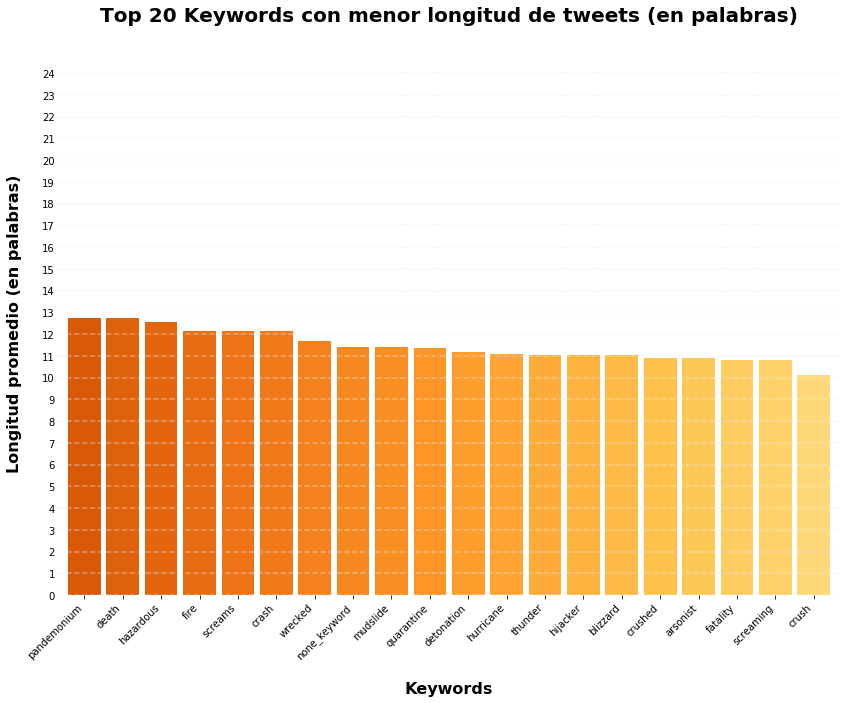

In [26]:
top20cortas_w = (keywords_representables['word_length_mean']).sort_values(ascending=False).tail(20)\
                .plot(kind='bar', figsize=(14,10), color=colores[::-1], width=0.85)

plt.xticks(rotation=45, ha='right')    
plt.yticks(np.arange(0, 25, 1.0))
plt.tick_params(axis='y', length=0)
plt.ylim(0, 25)

top20cortas_w.spines['right'].set_visible(False)
top20cortas_w.spines['top'].set_visible(False)
top20cortas_w.spines['left'].set_visible(False)
top20cortas_w.spines['bottom'].set_visible(False)

lineas = top20cortas_w.get_yticks()
for i in lineas:
      top20cortas_w.axhline(y=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
top20cortas_w.set_xlabel("Keywords", labelpad=20, weight='bold', size=16)
top20cortas_w.set_ylabel("Longitud promedio (en palabras)", labelpad=20, weight='bold', size=16)

plt.title("Top 20 Keywords con menor longitud de tweets (en palabras)", weight='bold', size=20, pad=30)

Text(0.5, 1.0, 'Top 20 Keywords más repetidas')

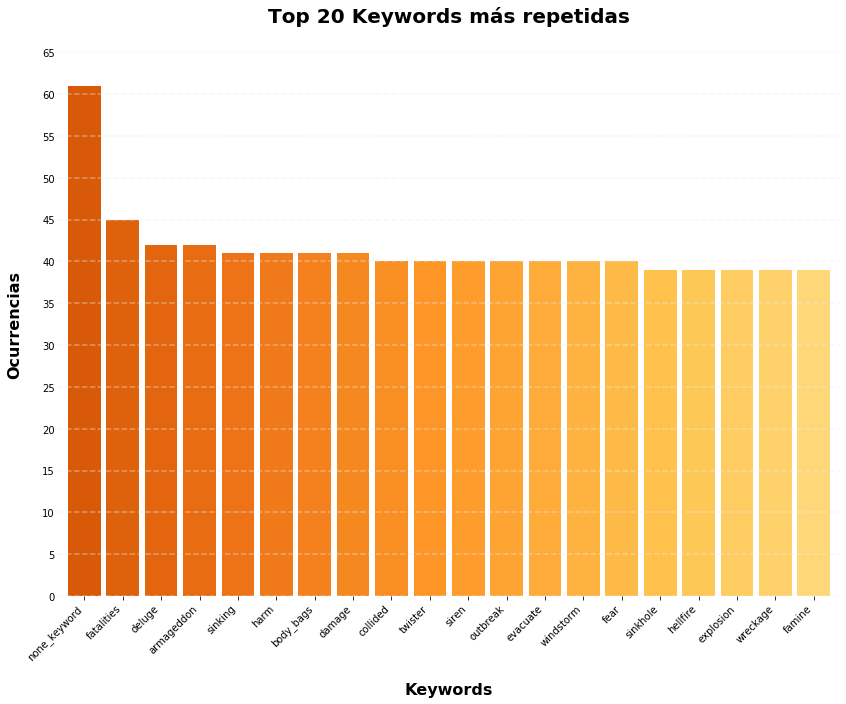

In [110]:
top20_repetidas = (keywords_representables['count']).sort_values(ascending=False).head(20)\
                .plot(kind='bar', figsize=(14,10), color=colores[::-1], width=0.85)

plt.xticks(rotation=45, ha='right')    
plt.yticks(np.arange(0, 75, 5.0))
plt.tick_params(axis='y', length=0)
plt.ylim(0, 65)

top20_repetidas.spines['right'].set_visible(False)
top20_repetidas.spines['top'].set_visible(False)
top20_repetidas.spines['left'].set_visible(False)
top20_repetidas.spines['bottom'].set_visible(False)

lineas = top20_repetidas.get_yticks()
for i in lineas:
      top20_repetidas.axhline(y=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
top20_repetidas.set_xlabel("Keywords", labelpad=20, weight='bold', size=16)
top20_repetidas.set_ylabel("Ocurrencias", labelpad=20, weight='bold', size=16)

plt.title("Top 20 Keywords más repetidas", weight='bold', size=20, pad=30)

Text(0.5, 1.0, 'Veracidad de Keywords vs. Longitud promedio (en caracteres)')

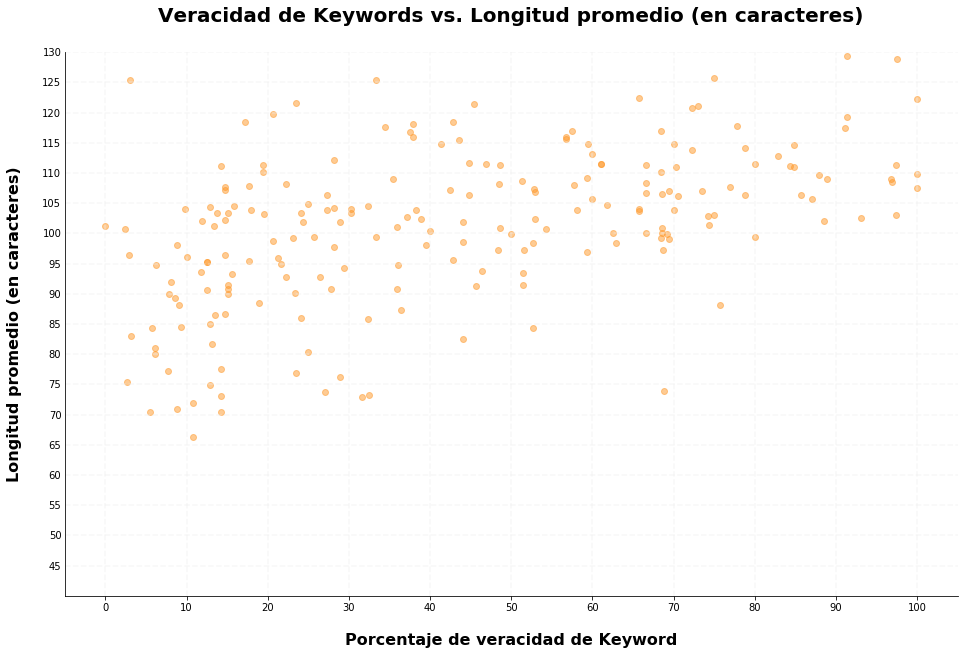

In [28]:
color_scatter = cmap(np.linspace(0.5, 0.7,1))

plt.figure(figsize=(16,10)) 
veracidad_vs_long_c = plt.subplot()

scatter = veracidad_vs_long_c.scatter(x=keywords_representables['veracity']*100,\
                                      y=keywords_representables['char_length_mean'], c=color_scatter[::-1], alpha=0.5)

plt.xticks(np.arange(0, 100+1, 10.0))
plt.yticks(np.arange(45, 135, 5.0))
plt.ylim(40, 130)
plt.xlim(-5, 105)

veracidad_vs_long_c.spines['right'].set_visible(False)
veracidad_vs_long_c.spines['top'].set_visible(False)
plt.tick_params(axis='y', length=0)

lineas_x = veracidad_vs_long_c.get_xticks()
for i in lineas_x:
      veracidad_vs_long_c.axvline(x=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
lineas_y = veracidad_vs_long_c.get_yticks()
for i in lineas_y:
      veracidad_vs_long_c.axhline(y=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
veracidad_vs_long_c.set_xlabel("Porcentaje de veracidad de Keyword", labelpad=20, weight='bold', size=16)
veracidad_vs_long_c.set_ylabel("Longitud promedio (en caracteres)", labelpad=20, weight='bold', size=16)

plt.title("Veracidad de Keywords vs. Longitud promedio (en caracteres)", weight='bold', size=20, pad=30)

Text(0.5, 1.0, 'Veracidad de Keywords vs. Longitud promedio (en palabras)')

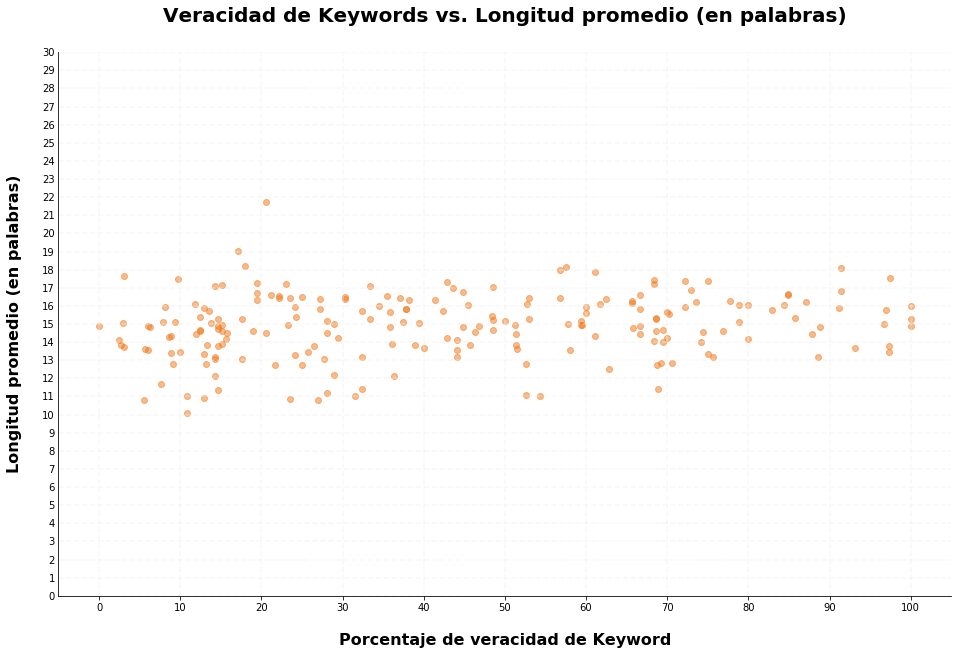

In [29]:
color_scatter = cmap(np.linspace(0.6, 0.7,1))

plt.figure(figsize=(16,10)) 
veracidad_vs_long_w = plt.subplot()

scatter = veracidad_vs_long_w.scatter(x=keywords_representables['veracity']*100,\
                                      y=keywords_representables['word_length_mean'], c=color_scatter[::-1], alpha=0.5)

plt.xticks(np.arange(0, 100+1, 10.0))
plt.yticks(np.arange(0, 30+1, 1.0))
plt.ylim(0, 30)
plt.xlim(-5, 105)

veracidad_vs_long_w.spines['right'].set_visible(False)
veracidad_vs_long_w.spines['top'].set_visible(False)
plt.tick_params(axis='y', length=0)

lineas_x = veracidad_vs_long_w.get_xticks()
for i in lineas_x:
      veracidad_vs_long_w.axvline(x=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
lineas_y = veracidad_vs_long_w.get_yticks()
for i in lineas_y:
      veracidad_vs_long_w.axhline(y=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
veracidad_vs_long_w.set_xlabel("Porcentaje de veracidad de Keyword", labelpad=20, weight='bold', size=16)
veracidad_vs_long_w.set_ylabel("Longitud promedio (en palabras)", labelpad=20, weight='bold', size=16)

plt.title("Veracidad de Keywords vs. Longitud promedio (en palabras)", weight='bold', size=20, pad=30)

Text(0.5, 1.0, 'Longitud promedio en palabras vs. Longitud promedio en caracteres\n(agrupados según Keyword)')

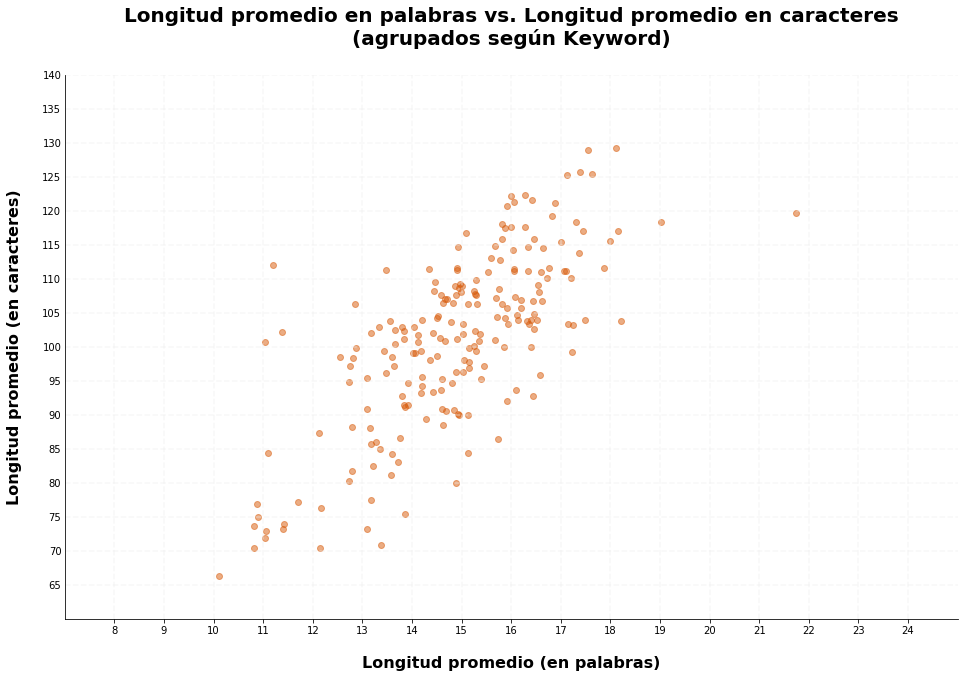

In [30]:
color_scatter = cmap(np.linspace(0.7, 0.8,1))

plt.figure(figsize=(16,10)) 
long_w_vs_long_c = plt.subplot()

scatter = long_w_vs_long_c.scatter(y=keywords_representables['char_length_mean'],\
                                      x=keywords_representables['word_length_mean'], c=color_scatter[::-1], alpha=0.5)

plt.xticks(np.arange(8, 24+1, 1.0))
plt.yticks(np.arange(65, 140+1, 5.0))
plt.ylim(60, 140)
plt.xlim(7, 25)

long_w_vs_long_c.spines['right'].set_visible(False)
long_w_vs_long_c.spines['top'].set_visible(False)
plt.tick_params(axis='y', length=0)

lineas_x = long_w_vs_long_c.get_xticks()
for i in lineas_x:
      long_w_vs_long_c.axvline(x=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
lineas_y = long_w_vs_long_c.get_yticks()
for i in lineas_y:
      long_w_vs_long_c.axhline(y=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
long_w_vs_long_c.set_xlabel("Longitud promedio (en palabras)", labelpad=20, weight='bold', size=16)
long_w_vs_long_c.set_ylabel("Longitud promedio (en caracteres)", labelpad=20, weight='bold', size=16)

plt.title("Longitud promedio en palabras vs. Longitud promedio en caracteres\n(agrupados según Keyword)", weight='bold', size=20, pad=30)

Text(0.5, 1.0, 'Veracidad vs. Frecuencia de keyword')

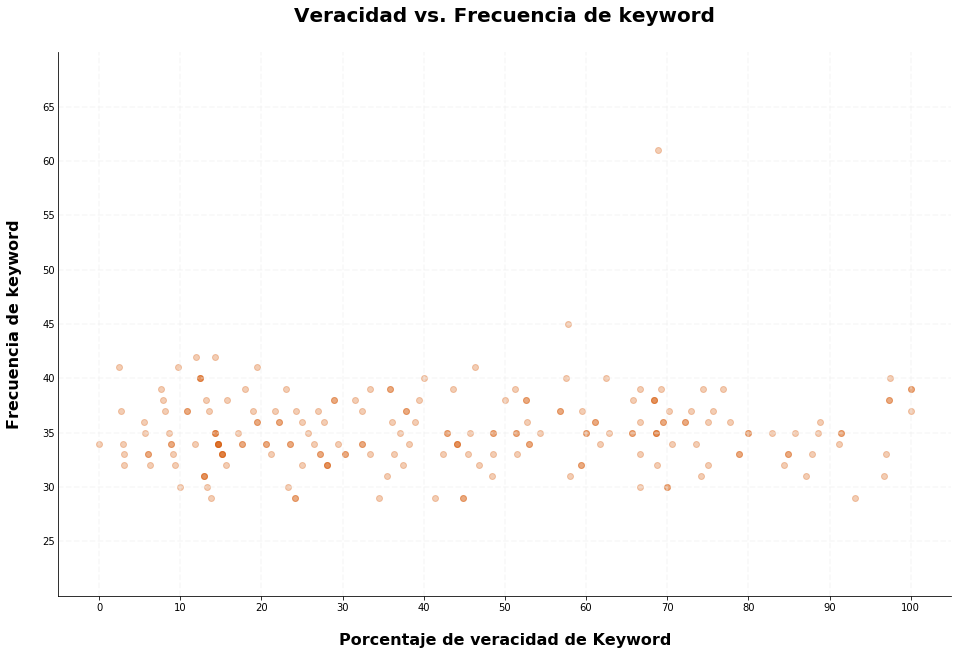

In [31]:
color_scatter = cmap(np.linspace(0.7, 0.8,1))

plt.figure(figsize=(16,10)) 
veracidad_vs_reps= plt.subplot()

scatter = veracidad_vs_reps.scatter(y=keywords_representables['count'],\
                                      x=keywords_representables['veracity']*100, c=color_scatter[::-1], alpha=0.3)

plt.xticks(np.arange(0, 100+1, 10.0))
plt.yticks(np.arange(25, 65+1, 5.0))
plt.ylim(20, 70)
plt.xlim(-5, 105)

veracidad_vs_reps.spines['right'].set_visible(False)
veracidad_vs_reps.spines['top'].set_visible(False)
plt.tick_params(axis='y', length=0)

lineas_x = veracidad_vs_reps.get_xticks()
for i in lineas_x:
      veracidad_vs_reps.axvline(x=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
lineas_y = veracidad_vs_reps.get_yticks()
for i in lineas_y:
      veracidad_vs_reps.axhline(y=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
veracidad_vs_reps.set_xlabel("Porcentaje de veracidad de Keyword", labelpad=20, weight='bold', size=16)
veracidad_vs_reps.set_ylabel("Frecuencia de keyword", labelpad=20, weight='bold', size=16)

plt.title("Veracidad vs. Frecuencia de keyword", weight='bold', size=20, pad=30)

In [32]:
color_wordcloud = cmap(np.linspace(0.2, .87,20))
colores_rgb = ()
for i in color_wordcloud:
    #convierto rgba en rgb
    aux = list(i)
    del aux[3]
    aux = (int(x * 255) for x in aux)
    aux =tuple(aux)
    colores_rgb = colores_rgb + (aux,)
    
print(colores_rgb)

((254, 235, 162), (254, 229, 150), (254, 221, 134), (254, 213, 115), (254, 204, 96), (254, 195, 78), (254, 183, 67), (254, 171, 57), (254, 159, 46), (251, 147, 38), (246, 135, 32), (241, 124, 26), (236, 112, 20), (227, 102, 15), (218, 92, 10), (209, 81, 4), (198, 73, 2), (183, 66, 2), (169, 59, 3), (154, 52, 3))


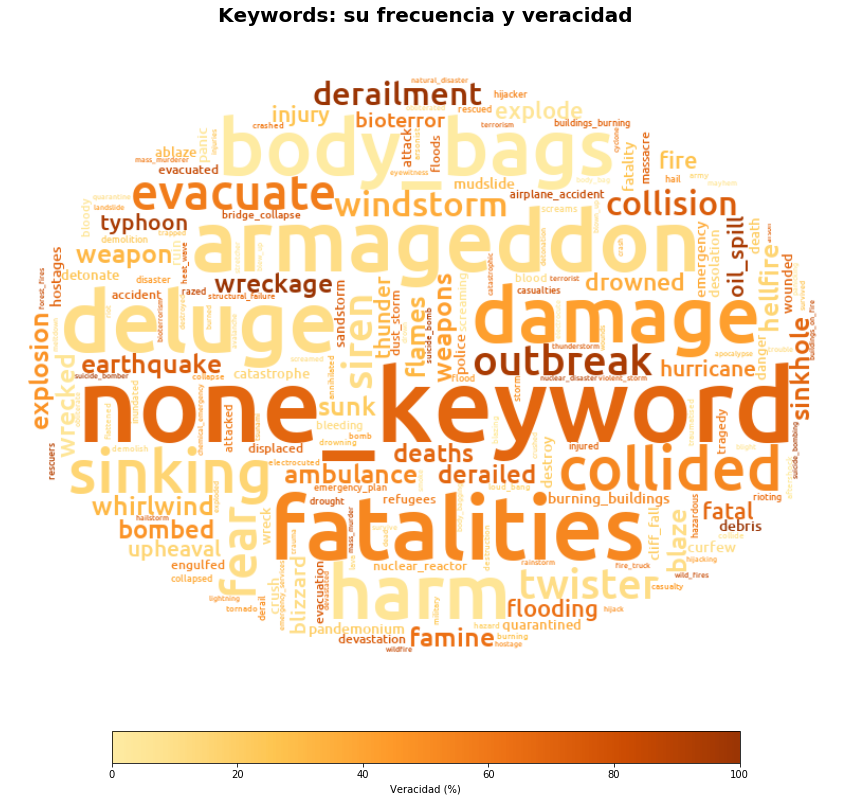

In [33]:
plt.figure(figsize=(15,15)) 

texto = tweets_final['keyword'].to_string().replace("%20", "_")
mask = np.array(Image.open("../TP1-Organizacion-de-Datos/imagenes/ovalo.png"))

keys = {}
keywords = tweets_por_keyword.index.tolist()
veracidades = tweets_por_keyword['veracity'].tolist()

for i in range(len(keywords)):
    keys[keywords[i]] = veracidades[i]

#cosa de mandinga, no tocar    
def my_tf_color_func(dictionary):
  def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
    return colores_rgb[int(dictionary[word]*19)]
  return my_tf_color_func_inner
    
    
wordcloud = WordCloud(font_path='../fonts/truetype/ubuntu/Ubuntu-M.ttf',collocations=False, colormap=cmap, \
                      relative_scaling=0.5, background_color='white', width=800, height=200, \
                      color_func=my_tf_color_func(keys), normalize_plurals=False, mask=mask, prefer_horizontal=0.5).generate(texto)

topes = mpl.colors.Normalize(vmin=0, vmax=100)
cmap_wordcloud = ListedColormap(cmap(np.linspace(0.2, 0.87, 256)))

plt.imshow(wordcloud, interpolation='bilinear')
plt.colorbar(cm.ScalarMappable(norm=topes, cmap=cmap_wordcloud), label='Veracidad (%)', \
             orientation='horizontal', shrink=0.75, pad=0.05)
plt.axis("off")
plt.title("Keywords: su frecuencia y veracidad", weight='bold', size=20, pad=30)
plt.show()

In [34]:
#10 kw+rep y 10 kw-rep
keywords_por_repeticiones = tweets_por_keyword.sort_values(by='count', ascending=False)
keywords_mas_y_menos_rep = keywords_por_repeticiones.head(10)
keywords_mas_y_menos_rep = keywords_mas_y_menos_rep.append(keywords_por_repeticiones.tail(10))
keywords_mas_y_menos_rep = keywords_mas_y_menos_rep.reset_index()

colores_fondo = []
fondo_1 = ["#fff19a"]*10
fondo_2 = ["#fed678"]*10
colores_fondo = fondo_1+fondo_2

ancho = 800
alto = 800
radio_int = 90
radio_ext = 350 - 10

valor_max = 65
valor_min = 0
a = (radio_ext - radio_int) / (valor_max - valor_min)
b = radio_int - a * valor_min

def radio(x):
    return a * x + b

angulo_mayor = 2.0 * np.pi / (len(keywords_mas_y_menos_rep) + 1)
angulo_menor = angulo_mayor / 3

p = figure(plot_width=ancho, plot_height=alto, title="Keywords con mayor y menor frecuencia", \
           x_axis_type=None, y_axis_type=None,x_range=(-420, 420), y_range=(-420, 420),\
           min_border=0, outline_line_color="black", background_fill_color="white")

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#cortes 
angulos = np.pi/2 - angulo_mayor/2 - keywords_mas_y_menos_rep.index.to_series()*angulo_mayor
p.annular_wedge(0, 0, radio_int, radio_ext, -angulo_mayor+angulos, angulos, color=colores_fondo)

# barras
p.annular_wedge(0, 0, outer_radius=radio(keywords_mas_y_menos_rep['count']),inner_radius=radio_int,\
                start_angle=-angulo_mayor+angulos+1*angulo_menor, end_angle=-angulo_mayor+angulos+2*angulo_menor,\
                color="#ee7315")

#circulos y labels
labels = np.linspace(60, 0, 7)
radii = a * labels + b
p.circle(0, 0, radius=radii, fill_color=None, line_color="white", line_dash="dashed")
p.text(0, radii, [str(r) for r in labels],text_font_size="11px", text_font_style="bold",\
       text_align="center", text_baseline="middle")

#ejes radiales
p.annular_wedge(0, 0, radio_int-10, radio_ext+10,-angulo_mayor+angulos, -angulo_mayor+angulos, color="black")

#keywords
xr = radii[0]*np.cos(np.array(-angulo_mayor/2 + angulos))
yr = radii[0]*np.sin(np.array(-angulo_mayor/2 + angulos))

angulo_label=np.array(-angulo_mayor/2+angulos)
angulo_label[angulo_label < -np.pi/2] += np.pi #doy vuelta los labels para facilitar la lectura
p.text(xr, yr, keywords_mas_y_menos_rep['keyword'], angle=angulo_label,
       text_font_size="14px", text_font_style="bold",text_align="center", text_baseline="middle")

#legendas
p.circle([-40, -40], [-370, -390], color=["#fff19a","#fed678"], radius=5)
p.text([-30, -30], [-370, -390], text=["Keywords más repetidas","Keywords menos repetidas"],
       text_font_size="11px", text_align="left", text_baseline="middle")

p.rect([-40], [0], width=30, height=13,
       color="#ee7315")
p.text([-15], [0], text=["Frecuencia"],
       text_font_size="12px", text_align="left", text_baseline="middle")

output_file("../TP1-Organizacion-de-Datos/graficos/frecuencia_keywords.html", title="frecuencia_keywords")
show(p)

# Relación de veracidad y longitud con palabras/caracteres específicos

#### Se buscará estudiar si existe una relación de los tweets que contienen nombres de ciudades/países, los que comienzan con mayúsculas, incluyen URLs o poseen los caracteres '#', '@', '¿?', '¡!', con la veracidad y longitud de los mismos. 

#### Se comienza leyendo el archivo de locaciones que se buscarán en los tweets.

In [35]:
ciudades = pd.read_csv('../TP1-Organizacion-de-Datos/csv/worldcities.csv')

In [36]:
ciudades.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6850,139.7514,Japan,JP,JPN,Tōkyō,primary,35676000.0,1392685764
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016
2,Mexico City,Mexico City,19.4424,-99.1310,Mexico,MX,MEX,Ciudad de México,primary,19028000.0,1484247881
3,Mumbai,Mumbai,19.0170,72.8570,India,IN,IND,Mahārāshtra,admin,18978000.0,1356226629
4,São Paulo,Sao Paulo,-23.5587,-46.6250,Brazil,BR,BRA,São Paulo,admin,18845000.0,1076532519


In [37]:
ciudad = ciudades['city_ascii'].str.lower()
paises = ciudades['country'].drop_duplicates().str.lower()
#iso2 = ciudades['iso2'].drop_duplicates().str.lower()
#iso3 = ciudades['iso3'].drop_duplicates().str.lower()
locaciones = pd.concat([ciudad, paises])
locaciones.count()

15716

#### Se crea el dataframe a utilizar para el estudio

In [38]:
elementos = ['#', '@', '¡,!', '¿,?', 'URL (http)', 'Locación', 'Comienza con mayúscula']
caracteristicas = pd.DataFrame(index=elementos)
caracteristicas

""
#
@
"¡,!"
"¿,?"
URL (http)
Locación
Comienza con mayúscula


In [39]:
caracteristicas['ocurrencias'] = 0
caracteristicas['ocurrencias_verd'] = 0
caracteristicas['long_prom_char'] = 0
caracteristicas['long_prom_char_v'] = 0
caracteristicas['long_prom_char_f'] = 0
caracteristicas['long_prom_word'] = 0
caracteristicas['long_prom_word_v'] = 0
caracteristicas['long_prom_word_f'] = 0
caracteristicas.head()

,ocurrencias,ocurrencias_verd,long_prom_char,long_prom_char_v,long_prom_char_f,long_prom_word,long_prom_word_v,long_prom_word_f
#,0,0,0,0,0,0,0,0
@,0,0,0,0,0,0,0,0
"¡,!",0,0,0,0,0,0,0,0
"¿,?",0,0,0,0,0,0,0,0
URL (http),0,0,0,0,0,0,0,0


#### Además, se crea un dataframe auxiliar para realizar las búsquedas

In [40]:
auxiliar = tweets_final.iloc[:,3:7]
auxiliar.head()

,text,about_disaster,char_length,word_length
0,Our Deeds are the Reason of this #earthquake M...,True,69,13
1,Forest fire near La Ronge Sask. Canada,True,38,7
2,All residents asked to 'shelter in place' are ...,True,133,22
3,"13,000 people receive #wildfires evacuation or...",True,65,8
4,Just got sent this photo from Ruby #Alaska as ...,True,88,16


#### Se definen las funciones buscadores de caracteres y ciudades.

In [41]:
def valores_calculados(auxiliar):
    
    encontrados = auxiliar['contains_element'].sum()
    verdaderos = auxiliar[auxiliar['about_disaster']==True]['contains_element'].sum()
    long_char = auxiliar[auxiliar['contains_element']==True]['char_length'].mean()
    long_char_v = auxiliar[(auxiliar['contains_element']==True) & (auxiliar['about_disaster']==True)]['char_length'].mean()
    long_char_f = auxiliar[(auxiliar['contains_element']==True) & (auxiliar['about_disaster']==False)]['char_length'].mean()
    long_word = longitud = auxiliar[auxiliar['contains_element']==True]['word_length'].mean()
    long_word_v = auxiliar[(auxiliar['contains_element']==True) & (auxiliar['about_disaster']==True)]['word_length'].mean()
    long_word_f = auxiliar[(auxiliar['contains_element']==True) & (auxiliar['about_disaster']==False)]['word_length'].mean()
    
    return encontrados, verdaderos, long_char, long_char_v, long_char_f, long_word, long_word_v, long_word_f

In [42]:
def buscar_caracteres(caracter1, caracter2=""):
    if caracter2 == "":
        auxiliar['contains_element'] = auxiliar['text'].str.contains(caracter1) 
    else: 
        auxiliar['contains_element'] = auxiliar['text'].str.contains('|'.join([caracter1, caracter2]))    
    return valores_calculados(auxiliar)

In [43]:
def buscar_inicial():
    iniciales = auxiliar['text'].str.slice(stop=1)
    auxiliar['contains_element'] = iniciales.str.isupper()
    return valores_calculados(auxiliar)    

In [44]:
# ejecutar luego de buscar_inicial, se puede arreglar pero son las 5am
def buscar_locaciones():
    auxiliar['contains_element'] = False
    auxiliar['text'] = auxiliar['text'].str.lower()
    for locacion in locaciones:
        auxiliar.loc[auxiliar['contains_element']==False, ['contains_element']] = (auxiliar.loc[auxiliar['contains_element']==False]['text']).str.contains(locacion, regex=False)
                
    return valores_calculados(auxiliar)

####  Se completa el dataframe

In [45]:
caracteristicas.loc['#',:] = buscar_caracteres('#')
caracteristicas.loc['@',:] =  buscar_caracteres('@')
caracteristicas.loc['¿,?',:] =  buscar_caracteres('\?', '¿')
caracteristicas.loc['¡,!',:] =  buscar_caracteres('!', '¡')
caracteristicas.loc['URL (http)',:] = buscar_caracteres('http')
caracteristicas.head()

,ocurrencias,ocurrencias_verd,long_prom_char,long_prom_char_v,long_prom_char_f,long_prom_word,long_prom_word_v,long_prom_word_f
#,1761,875,113.893242,116.859429,110.963883,15.466212,15.640000,15.294582
@,2039,676,101.921040,109.664201,98.080704,15.286415,15.918639,14.972854
"¡,!",721,197,104.717060,109.045685,103.089695,15.889043,16.345178,15.717557
"¿,?",1042,292,92.758157,99.993151,89.941333,14.762956,15.229452,14.581333
URL (http),3971,2172,110.103500,111.693831,108.183435,14.242005,14.404696,14.045581


In [46]:
caracteristicas.loc['Comienza con mayúscula',:] = buscar_inicial()
caracteristicas

,ocurrencias,ocurrencias_verd,long_prom_char,long_prom_char_v,long_prom_char_f,long_prom_word,long_prom_word_v,long_prom_word_f
#,1761,875,113.893242,116.859429,110.963883,15.466212,15.640000,15.294582
@,2039,676,101.921040,109.664201,98.080704,15.286415,15.918639,14.972854
"¡,!",721,197,104.717060,109.045685,103.089695,15.889043,16.345178,15.717557
"¿,?",1042,292,92.758157,99.993151,89.941333,14.762956,15.229452,14.581333
URL (http),3971,2172,110.103500,111.693831,108.183435,14.242005,14.404696,14.045581
Locación,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Comienza con mayúscula,4911,2239,101.293219,107.351943,96.216317,14.735492,14.868691,14.623877


In [47]:
caracteristicas.loc['Locación',:] = buscar_locaciones()
caracteristicas

,ocurrencias,ocurrencias_verd,long_prom_char,long_prom_char_v,long_prom_char_f,long_prom_word,long_prom_word_v,long_prom_word_f
#,1761,875,113.893242,116.859429,110.963883,15.466212,15.640000,15.294582
@,2039,676,101.921040,109.664201,98.080704,15.286415,15.918639,14.972854
"¡,!",721,197,104.717060,109.045685,103.089695,15.889043,16.345178,15.717557
"¿,?",1042,292,92.758157,99.993151,89.941333,14.762956,15.229452,14.581333
URL (http),3971,2172,110.103500,111.693831,108.183435,14.242005,14.404696,14.045581
Locación,6938,3103,104.780628,110.162101,100.426336,15.448112,15.457622,15.440417
Comienza con mayúscula,4911,2239,101.293219,107.351943,96.216317,14.735492,14.868691,14.623877


In [48]:
caracteristicas['ocurrencias_falsas'] = caracteristicas['ocurrencias']-caracteristicas['ocurrencias_verd']

In [49]:
caracteristicas['veracidad'] = caracteristicas['ocurrencias_verd']/caracteristicas['ocurrencias']
caracteristicas

,ocurrencias,ocurrencias_verd,long_prom_char,long_prom_char_v,long_prom_char_f,long_prom_word,long_prom_word_v,long_prom_word_f,ocurrencias_falsas,veracidad
#,1761,875,113.893242,116.859429,110.963883,15.466212,15.640000,15.294582,886,0.496877
@,2039,676,101.921040,109.664201,98.080704,15.286415,15.918639,14.972854,1363,0.331535
"¡,!",721,197,104.717060,109.045685,103.089695,15.889043,16.345178,15.717557,524,0.273232
"¿,?",1042,292,92.758157,99.993151,89.941333,14.762956,15.229452,14.581333,750,0.280230
URL (http),3971,2172,110.103500,111.693831,108.183435,14.242005,14.404696,14.045581,1799,0.546965
Locación,6938,3103,104.780628,110.162101,100.426336,15.448112,15.457622,15.440417,3835,0.447247
Comienza con mayúscula,4911,2239,101.293219,107.351943,96.216317,14.735492,14.868691,14.623877,2672,0.455915


#### Se reordena el dataframe

In [50]:
caracteristicas = caracteristicas[['ocurrencias_verd', 'ocurrencias_falsas', 'ocurrencias', 'veracidad', 'long_prom_char', 'long_prom_char_v', 'long_prom_char_f', 'long_prom_word', 'long_prom_word_v', 'long_prom_word_f']]
caracteristicas

,ocurrencias_verd,ocurrencias_falsas,ocurrencias,veracidad,long_prom_char,long_prom_char_v,long_prom_char_f,long_prom_word,long_prom_word_v,long_prom_word_f
#,875,886,1761,0.496877,113.893242,116.859429,110.963883,15.466212,15.640000,15.294582
@,676,1363,2039,0.331535,101.921040,109.664201,98.080704,15.286415,15.918639,14.972854
"¡,!",197,524,721,0.273232,104.717060,109.045685,103.089695,15.889043,16.345178,15.717557
"¿,?",292,750,1042,0.280230,92.758157,99.993151,89.941333,14.762956,15.229452,14.581333
URL (http),2172,1799,3971,0.546965,110.103500,111.693831,108.183435,14.242005,14.404696,14.045581
Locación,3103,3835,6938,0.447247,104.780628,110.162101,100.426336,15.448112,15.457622,15.440417
Comienza con mayúscula,2239,2672,4911,0.455915,101.293219,107.351943,96.216317,14.735492,14.868691,14.623877


#### Se procede a graficar las relaciones deseadas

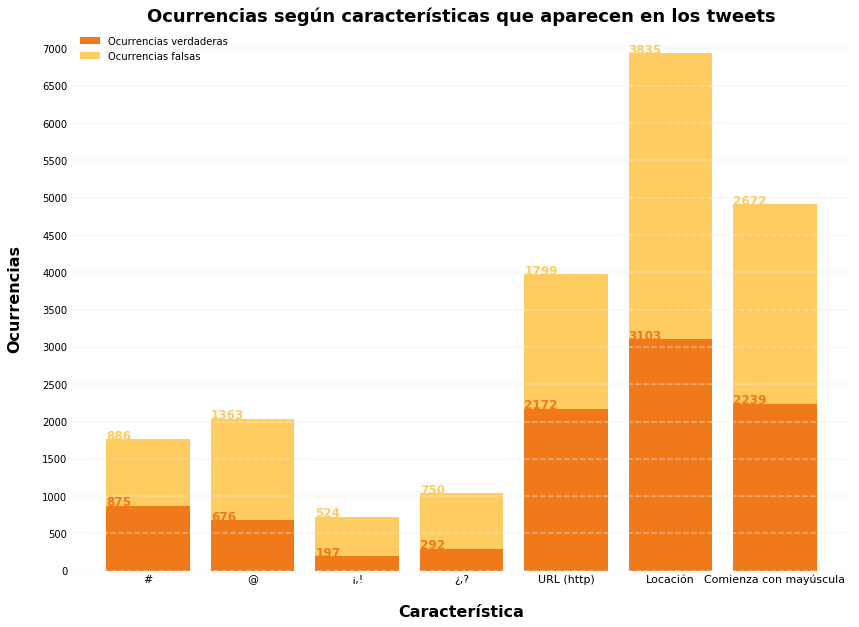

In [51]:
plt.figure(figsize=(14,10))
ocurrencias = plt.subplot()

x = caracteristicas.index.to_list()
ocurr_verd = caracteristicas['ocurrencias_verd']
ocurr_falsas = caracteristicas['ocurrencias_falsas']

ocurrencias.bar(x=x, height=ocurr_verd, color=colores[14], label = 'Ocurrencias verdaderas')
ocurrencias.bar(x=x, height=ocurr_falsas, bottom=ocurr_verd, color= colores[2], label = 'Ocurrencias falsas')

saltos_y = np.linspace(0, 7000, 15)
plt.yticks(saltos_y)
plt.xticks(fontsize = 11)

ocurrencias.spines['right'].set_visible(False)
ocurrencias.spines['top'].set_visible(False)
ocurrencias.spines['bottom'].set_visible(False)
ocurrencias.spines['left'].set_visible(False)
plt.tick_params(axis='both', length=0)

lineas = ocurrencias.get_yticks()
for i in lineas:
    ocurrencias.axhline(y=i, linestyle='--', alpha=0.5, color='#eeeeee')

for x, y in enumerate(ocurr_verd):
    ocurrencias.text(x-0.4, y + .35, str(y), color=colores[14], fontweight='bold', fontsize=12)

for x, y in enumerate(ocurr_falsas+ocurr_verd):
    ocurrencias.text(x-0.4, y +.35, str(ocurr_falsas[x]), color=colores[2], fontweight='bold', fontsize=12)    

ocurrencias.set_xlabel("Característica", labelpad=20, weight='bold', size=16)
ocurrencias.set_ylabel("Ocurrencias", labelpad=20, weight='bold', size=16)
plt.legend(frameon=False, loc='best', fontsize=10)
plt.title("Ocurrencias según características que aparecen en los tweets", weight='bold', size=18)

plt.show()

Text(0.5, 1.0, 'Longitud promedio (en caracteres) de los tweets \nsegún característica que poseen')

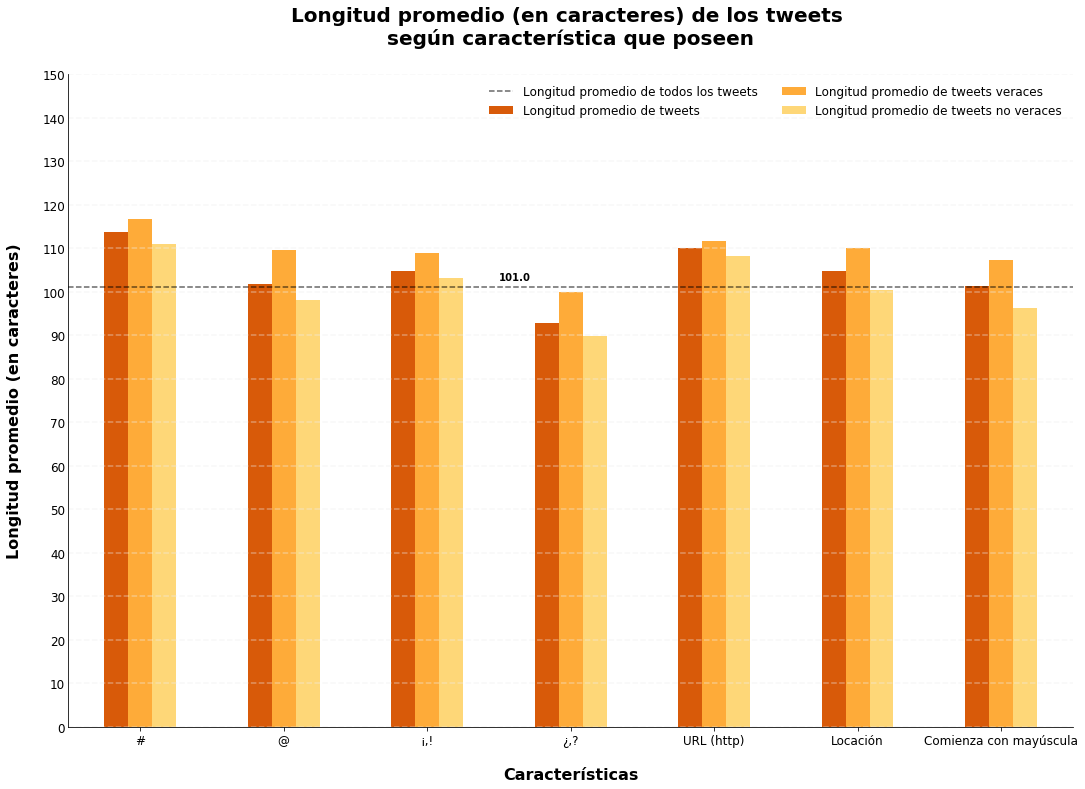

In [103]:
long = caracteristicas.loc[:,['long_prom_char', 'long_prom_char_v', 'long_prom_char_f']].\
        plot.bar(figsize = (18,12), rot=0, color=[colores[19], colores[7],colores[0]])

promedio = tweets_final['char_length'].mean()    
    
long.hlines(y=promedio, xmin=-.5, xmax=6.5, color='black', \
                   alpha=0.6, linestyle = '--', label='Longitud promedio de todos los tweets')

plt.yticks(np.arange(0, 160, 10.0))

long.spines['right'].set_visible(False)
long.spines['top'].set_visible(False)
plt.tick_params(axis='y', length=0)
        
lineas_y = long.get_yticks()
for i in lineas_y:
      long.axhline(y=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
long.set_xticklabels(elementos)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)
long.set_xlabel("Características", labelpad=20, weight='bold', size=16)
long.set_ylabel("Longitud promedio (en caracteres)", labelpad=20, weight='bold', size=16)

leyenda = long.legend(frameon=False, loc='best', ncol=2, fontsize=12)
leyenda.get_texts()[1].set_text('Longitud promedio de tweets')
leyenda.get_texts()[2].set_text('Longitud promedio de tweets veraces')
leyenda.get_texts()[3].set_text('Longitud promedio de tweets no veraces')
long.text(2.5, promedio+1.7, str(np.round(promedio, 1)), color='black', fontweight='bold', fontsize=10)   

plt.title("Longitud promedio (en caracteres) de los tweets \nsegún característica que poseen", weight='bold', size=20, pad=30)

Text(0.5, 1.0, 'Longitud promedio (en caracteres) de los tweets \nsegún característica que poseen')

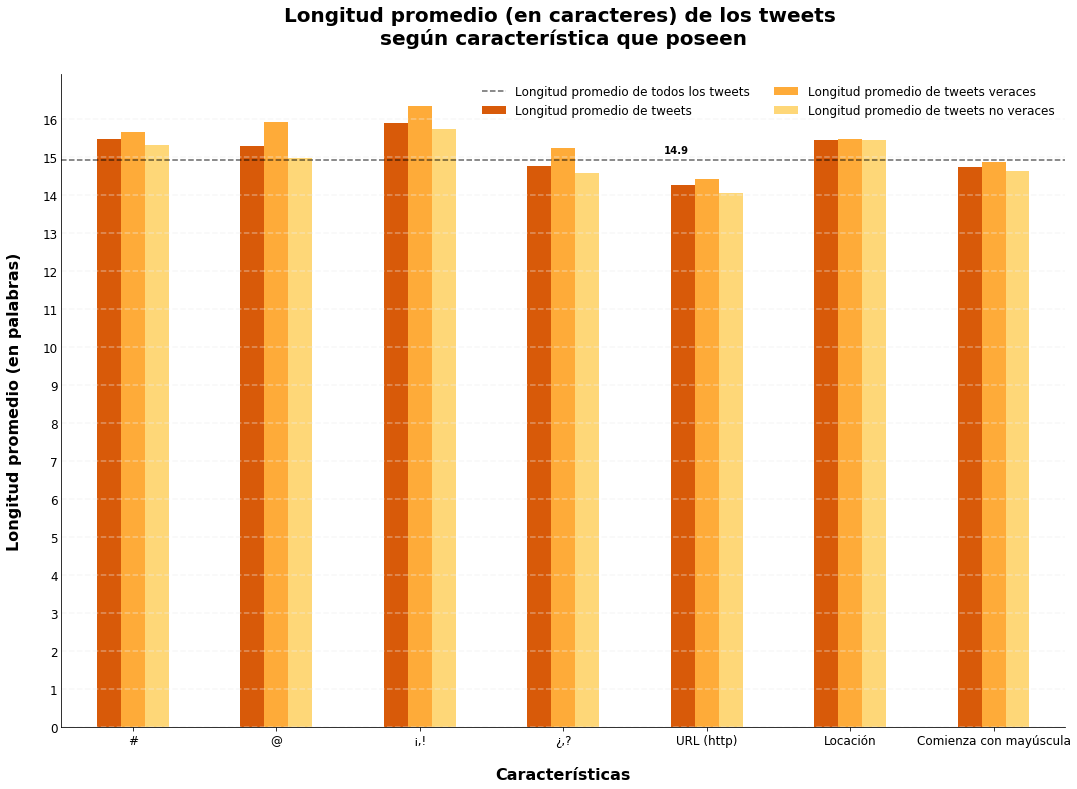

In [109]:
long = caracteristicas.loc[:,['long_prom_word', 'long_prom_word_v', 'long_prom_word_f']].\
        plot.bar(figsize = (18,12), rot=0, color=[colores[19], colores[7],colores[0]])

promedio = tweets_final['word_length'].mean()    
    
long.hlines(y=tweets_final['word_length'].mean(), xmin=-.5, xmax=6.5, color='black', \
                   alpha=0.6, linestyle = '--', label='Longitud promedio de todos los tweets')

plt.yticks(np.arange(0, 17, 1.0))

long.spines['right'].set_visible(False)
long.spines['top'].set_visible(False)
plt.tick_params(axis='y', length=0)
        
lineas_y = long.get_yticks()
for i in lineas_y:
      long.axhline(y=i, linestyle='--', alpha=0.4, color='#eeeeee')
        
long.set_xticklabels(elementos)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)
long.set_xlabel("Características", labelpad=20, weight='bold', size=16)
long.set_ylabel("Longitud promedio (en palabras)", labelpad=20, weight='bold', size=16)

leyenda = long.legend(frameon=False, loc='best', ncol=2, fontsize=12)
leyenda.get_texts()[1].set_text('Longitud promedio de tweets')
leyenda.get_texts()[2].set_text('Longitud promedio de tweets veraces')
leyenda.get_texts()[3].set_text('Longitud promedio de tweets no veraces')
long.text(3.7, promedio+0.2, str(np.round(promedio, 1)), color='black', fontweight='bold', fontsize=10)   

plt.title("Longitud promedio (en caracteres) de los tweets \nsegún característica que poseen", weight='bold', size=20, pad=30)